In [1]:
# Check om alt er nødvendigt her...

import os
import cv2
from iptcinfo3 import IPTCInfo
from PIL import Image, IptcImagePlugin
import re
import zipfile
import shutil
import numpy as np
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# linux location:
linux_dir1raw = '/home/xpn381/data/johan_test1/raw/'
linux_dir1edit = '/home/xpn381/data/johan_test1/edit/'
linux_dir2 = '/home/xpn381/data/johan_test2/'

# Patch IPTC:

In [4]:
def get_city_imgs(linux_dir):
    city_imgs = [] # list of images with city in them:
    city_info = (2, 90)

    for img in os.listdir(linux_dir2):
        img_path = os.path.join(linux_dir2, img)

        im = Image.open(img_path)
        info = IptcImagePlugin.getiptcinfo(im)

        if info != None:
            if city_info in info.keys(): 
                city_imgs.append(img_path)

            else:
                pass
            
    return(city_imgs)

In [5]:
# and those you now want date and time from:
# NOPE! you want to tjek city vs discription - men det bliver kun elevant hvis der er rigtigt mange billeder i edit..

# Make city_imgs list and df

In [18]:
def make_city_df(linux_dir):

    city_imgs = get_city_imgs(linux_dir2)

    city_info = (2, 90)
    date_info = (2, 55)
    time_info = (2, 60)

    np.random.seed(2015)
    data = []

    for img_path in city_imgs:
        im = Image.open(img_path)
        info = IptcImagePlugin.getiptcinfo(im) 

        img_id = img_path
        city = info[city_info].decode("utf-8")
        date = int(info[date_info].decode("utf-8"))
        time = int(info[time_info].decode("utf-8")[:-5]) # er det sidste tidszoner og kan det bruges til noget?
        
        data.append({'id':img_id,'city': city, 'date':date, 'time':time})

    df = pd.DataFrame(data)
    
    df['stand_date'] = (df['date']-df['date'].mean())/df['date'].std()
    df['stand_time'] = (df['time']-df['time'].mean())/df['time'].std()
    
    df['norm_date'] = (df['date']-df['date'].min())/(df['date'].max() - df['date'].min())
    df['norm_time'] = (df['time']-df['time'].min())/(df['time'].max() - df['time'].min())
    
    return(df, city_imgs)

In [19]:
df, city_imgs = make_city_df(linux_dir2)

In [8]:
df.describe()

,date,time,stand_date,stand_time,norm_date,norm_time
count,6.800000e+01,68.000000,6.800000e+01,6.800000e+01,68.000000,68.000000
mean,2.009093e+07,137255.220588,-2.731004e-09,-2.612289e-16,0.352941,0.528699
std,4.814377e-01,27755.329156,1.000000e+00,1.000000e+00,0.481438,0.348952
min,2.009093e+07,95203.000000,-7.330983e-01,-1.515104e+00,0.000000,0.000000
25%,2.009093e+07,110786.250000,-7.330983e-01,-9.536536e-01,0.000000,0.195920
50%,2.009093e+07,135607.000000,-7.330983e-01,-5.938393e-02,0.000000,0.507977
75%,2.009093e+07,172561.250000,1.344014e+00,1.272045e+00,1.000000,0.972583
max,2.009093e+07,174742.000000,1.344014e+00,1.350616e+00,1.000000,1.000000


In [9]:
print(df[df['city'] == 'Baghdad'].shape[0])
print(df[df['city'] != 'Baghdad'].shape[0])

18
50


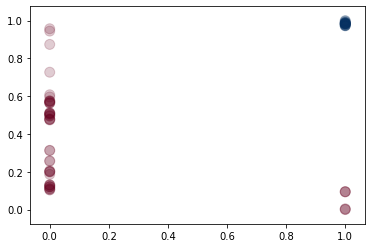

In [47]:
city_dum = (df['city'] == df['city'][0])*1 
plt.scatter(df['norm_date'], df['norm_time'], s = 100, c = city_dum, cmap =plt.cm.RdBu_r, alpha = 0.2)
plt.show()

# Extract dates and time for those that misses

# Training model:
put shit into functions fukface,

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [12]:
# clf = SVC(kernel='rbf', gamma='auto', probability=True)
clf = SVC(kernel='rbf', gamma=10, probability=True)

X = df[['norm_date','norm_time']]
y = df['city']

# clf.fit(X_train, y_train)
clf.fit(X, y)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [14]:
print(f"Predicted city (insample): {clf.predict(np.array(df[['norm_date','norm_time']].iloc[0]).reshape(1,-1))[0]}")
print(f"Prob of predicted city: {np.max(clf.predict_proba(np.array(df[['date','norm_time']].iloc[0]).reshape(1,-1))):.2}")
print(f"True city: {df['city'].iloc[0]}")

Predicted city (insample): Kirkuk
Prob of predicted city: 0.92
True city: Kirkuk


In [15]:
print(f"Predicted city (insample): {clf.predict(np.array(df[['norm_date','norm_time']].iloc[-1]).reshape(1,-1))[0]}")
print(f"Prob of predicted city: {np.max(clf.predict_proba(np.array(df[['norm_date','norm_time']].iloc[-1]).reshape(1,-1))):.2}")
print(df['city'].iloc[-1])

Predicted city (insample): Baghdad
Prob of predicted city: 0.95
Baghdad


Text(0.5, 1.0, 'SVM RBF')

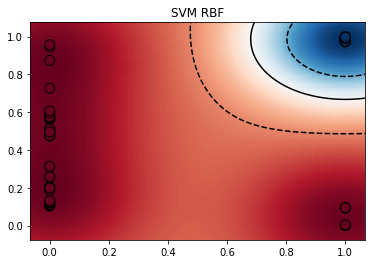

In [48]:
plt.figure()
plt.clf()
plt.scatter(df['norm_date'], df['norm_time'], c=city_dum, zorder=10, cmap=plt.cm.RdBu_r, s=100, edgecolor='k')
# plt.scatter(df['norm_date'], df['norm_time'], c=city_dum, zorder=10, cmap=plt.cm.Paired, s=100, edgecolor='k')  #with the binary colors


    # Circle out the test data
#     plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none', zorder=10)

plt.axis('tight')

x_min = df['norm_date'].min() - 0.1 # 0.1 just to fill the whole plot...
x_max = df['norm_date'].max() + 0.1
y_min = df['norm_time'].min() - 0.1
y_max = df['norm_time'].max() + 0.1

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
# plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired) #binary: also works fine
plt.pcolormesh(XX, YY, Z, cmap= plt.cm.RdBu_r)  

plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

plt.title('SVM RBF')

### Need a bit more data to make it out-of-sample

# Prediction:
 so now you find the date and time for all other images in the folder and then predict:

# Extract date and time to IPCT for images missing it.
#### should come before model..

JSpanner_Petraeus_0959.JPG


KeyError: (2, 90)

In [64]:
info

{(2, 0): b'\x00\x00'}

In [60]:
no_iptc_img = []

for img in os.listdir(linux_dir2):
    image_path = os.path.join(linux_dir2, img)
    
    if image_path not in city_imgs:
        
        im = Image.open(img_path)
        info = IptcImagePlugin.getiptcinfo(im)
        print(img)
        print(f'{info}\n')

#         info = IPTCInfo(image_path, force=True)
    
    
    

15688843917294343JSpanner_Kirkuk_Tribes_3071.JPG
{(2, 0): b'\x00\x00'}

15688843917299256JSpanner_Kirkuk_Tribes_3079.JPG
{(2, 0): b'\x00\x00'}

1568884391730428JSpanner_Kirkuk_Tribes_3092.JPG
{(2, 0): b'\x00\x00'}

15688843917309902JSpanner_Kirkuk_Tribes_3097.JPG
{(2, 0): b'\x00\x00'}

15688843917320557JSpanner_Kirkuk_Tribes_3119.JPG
{(2, 0): b'\x00\x00'}

15688843917330525JSpanner_Kirkuk_Tribes_3135.JPG
{(2, 0): b'\x00\x00'}

1568884391733567JSpanner_Kirkuk_Tribes_3158.JPG
{(2, 0): b'\x00\x00'}

1568884391734038JSpanner_Kirkuk_Tribes_3169.JPG
{(2, 0): b'\x00\x00'}

15688843917345345JSpanner_Kirkuk_Tribes_3185.JPG
{(2, 0): b'\x00\x00'}

15688843917350085JSpanner_Kirkuk_Tribes_3190.JPG
{(2, 0): b'\x00\x00'}

15688843917354825JSpanner_Kirkuk_Tribes_3225.JPG
{(2, 0): b'\x00\x00'}

15688843917359812JSpanner_Kirkuk_Tribes_3264.JPG
{(2, 0): b'\x00\x00'}

15688843917364585JSpanner_Kirkuk_Tribes_3271.JPG
{(2, 0): b'\x00\x00'}

15688843917369337JSpanner_Kirkuk_Tribes_3310.JPG
{(2, 0): b'\x00\x0

In [55]:
no_iptc_img = []

for img in os.listdir(linux_dir2):
    image_path = os.path.join(linux_dir2, img)
    
    if image_path not in city_imgs:
        
        try:
            im = Image.open(img_path)
            info = IptcImagePlugin.getiptcinfo(im)
        
        except:
            no_iptc_img.append(image_path)
            print(img)
        
#         info = IPTCInfo(image_path, force=True)
    
    
    

In [56]:
no_iptc_img

[]

In [ ]:
def get_date(linux_dir):
    
    '''Function wich takes as input path of dirs. in those dirs the function will irreterate throug all jpg, extract a date from their meta date and it a IPTC protocol'''
    
    # get the image name from the dir DATADIR_RAW
    for img in os.listdir(linux_dir):
        image_path = os.path.join(linux_dir, img)
        info = IPTCInfo(image_path, force=True)
        print(img)
        
        # Open the image and access the metadate. Use regex to extract date:
        image = Image.open(image_path) 
        txt = str(image.info['exif']) # exif are mostly JPEG
        #  maybe but re in a try, to avoide None_type error....
        r  = '[\d]{4}:[\d]{2}:[\d]{2}' # format yyyy:mm:dd
        date = re.search(r, txt).group().replace(':','')
        print(f'date of picture: {date}')
        
        # Force open the IPTC protocol to insert date
        info = IPTCInfo(image_path, force=True)
        print(f"info before: {info['date created']}") #Before. Shows wheter or not the entry was empty before
        info['date created'] = date 
        print(f"info after: {info['date created']}") # after. Shows the date extracted from the meta data
        print('\n')
        
        # Create the new dir DATADIR_RAW_NEW if it does not already exist
        if not os.path.exists(DATADIR_RAW_NEW):
            os.makedirs(DATADIR_RAW_NEW)
        
        # Create the new path for the image
        new_path = os.path.join(DATADIR_RAW_NEW, 'new' + img)
        
        # If that image is already in the path, delete it.
        if os.path.exists(DATADIR_RAW_NEW):
            try:
                os.remove(new_path)
            except:
                pass
        
        # Save new image.
        info.save_as(new_path)

# Run function
get_date(DATADIR_RAW,DATADIR_RAW_NEW)

In [50]:
city_imgs

['/home/xpn381/data/johan_test2/15688843917294343JSpanner_Kirkuk_Tribes_3071.JPG',
 '/home/xpn381/data/johan_test2/15688843917299256JSpanner_Kirkuk_Tribes_3079.JPG',
 '/home/xpn381/data/johan_test2/1568884391730428JSpanner_Kirkuk_Tribes_3092.JPG',
 '/home/xpn381/data/johan_test2/15688843917309902JSpanner_Kirkuk_Tribes_3097.JPG',
 '/home/xpn381/data/johan_test2/15688843917320557JSpanner_Kirkuk_Tribes_3119.JPG',
 '/home/xpn381/data/johan_test2/15688843917330525JSpanner_Kirkuk_Tribes_3135.JPG',
 '/home/xpn381/data/johan_test2/1568884391733567JSpanner_Kirkuk_Tribes_3158.JPG',
 '/home/xpn381/data/johan_test2/1568884391734038JSpanner_Kirkuk_Tribes_3169.JPG',
 '/home/xpn381/data/johan_test2/15688843917345345JSpanner_Kirkuk_Tribes_3185.JPG',
 '/home/xpn381/data/johan_test2/15688843917350085JSpanner_Kirkuk_Tribes_3190.JPG',
 '/home/xpn381/data/johan_test2/15688843917354825JSpanner_Kirkuk_Tribes_3225.JPG',
 '/home/xpn381/data/johan_test2/15688843917359812JSpanner_Kirkuk_Tribes_3264.JPG',
 '/home

First the ones with no IPCTs.

In [31]:
city_info = (2, 90)
date_info = (2, 55)
time_info = (2, 60)

for img in os.listdir(linux_dir2):
    if img not in city_imgs:
        img_path = os.path.join(linux_dir2, img)
            
        
        im = Image.open(img_path)
        info = IptcImagePlugin.getiptcinfo(im)
        
        print(info[date_info])
        

b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20090929'
b'20

KeyError: (2, 55)

# Plot might work with more data....

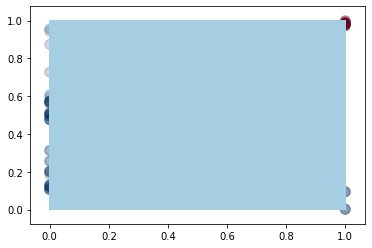

In [83]:
plt.figure()
plt.clf()
# plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired, edgecolor='k', s=20)
plt.scatter(df['norm_date'], df['norm_time'], s = 100, c = city_dum, cmap ='RdBu', alpha = 0.2)


# Circle out the test data
# plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none', zorder=10, edgecolor='k')


plt.axis('tight')
# x_min = X[:, 0].min()
# x_max = X[:, 0].max()
# y_min = X[:, 1].min()
# y_max = X[:, 1].max()

x_min = df['norm_date'].min()
x_max = df['norm_date'].max()
y_min = df['norm_time'].min()
y_max = df['norm_time'].max()


XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

# plt.title(kernel)
plt.show()

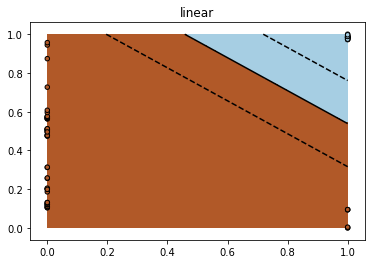

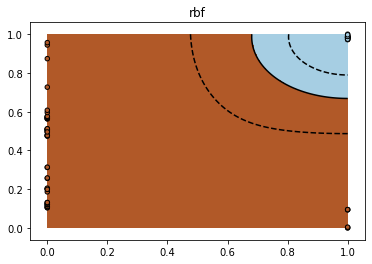

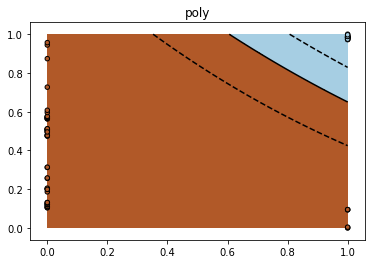

In [147]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm


X = df[['norm_date','norm_time']]
y = df['city']

n_sample = len(X)

np.random.seed(0)
#order = np.random.permutation(n_sample)
#X = X[order]
#y = y[order].astype(np.float)

X_train = X[:int(.9 * n_sample)]
y_train = y[:int(.9 * n_sample)]
X_test = X[int(.9 * n_sample):]
y_test = y[int(.9 * n_sample):]

# fit the model
for kernel in ('linear', 'rbf', 'poly'):
    clf = svm.SVC(kernel=kernel, gamma=10)
    clf.fit(X_train, y_train)

    plt.figure()
    plt.clf()
    plt.scatter(X['norm_date'], X['norm_time'], c=city_dum, zorder=10, cmap=plt.cm.Paired, s=20, edgecolor='k')

    # Circle out the test data
#     plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none', zorder=10)

    plt.axis('tight')
    # x_min = X[:, 0].min()
    # x_max = X[:, 0].max()
    # y_min = X[:, 1].min()
    # y_max = X[:, 1].max()

    x_min = df['norm_date'].min()
    x_max = df['norm_date'].max()
    y_min = df['norm_time'].min()
    y_max = df['norm_time'].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

    plt.title(kernel)
plt.show()

In [80]:
y

array([1., 2., 1., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 2., 1., 2., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2.,
       2., 1., 1., 2., 2., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       2., 1., 1., 1., 2., 1., 1., 1., 2., 1., 1., 2., 2., 2., 2., 1., 2.,
       1., 2., 1., 1., 1., 2., 2., 2., 1., 2., 2., 2., 1., 1., 2., 1., 1.,
       2., 2., 1., 2., 2., 2., 1., 1., 2., 1., 2., 2., 2., 1., 1.])

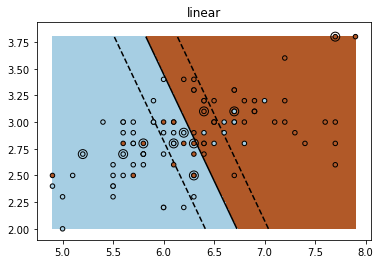

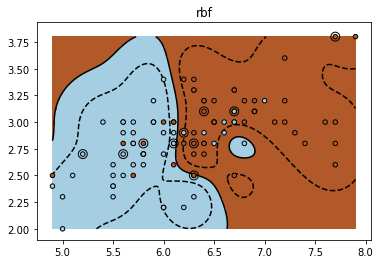

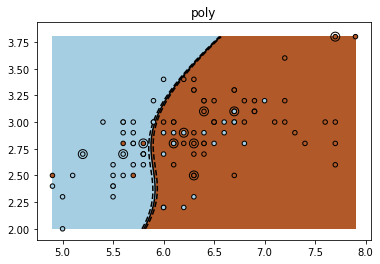

In [129]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm

iris = datasets.load_iris()
X = iris.data
y = iris.target

X = X[y != 0, :2]
y = y[y != 0]

n_sample = len(X)

np.random.seed(0)
order = np.random.permutation(n_sample)
X = X[order]
y = y[order].astype(np.float)

X_train = X[:int(.9 * n_sample)]
y_train = y[:int(.9 * n_sample)]
X_test = X[int(.9 * n_sample):]
y_test = y[int(.9 * n_sample):]

# fit the model
for kernel in ('linear', 'rbf', 'poly'):
    clf = svm.SVC(kernel=kernel, gamma=10)
    clf.fit(X_train, y_train)

    plt.figure()
    plt.clf()
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired,
                edgecolor='k', s=20)

    # Circle out the test data
    plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none',
                zorder=10, edgecolor='k')

    plt.axis('tight')
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

    plt.title(kernel)
plt.show()

In [54]:
clf

1.0

(-3.0, 3.0, -3.0, 3.0)

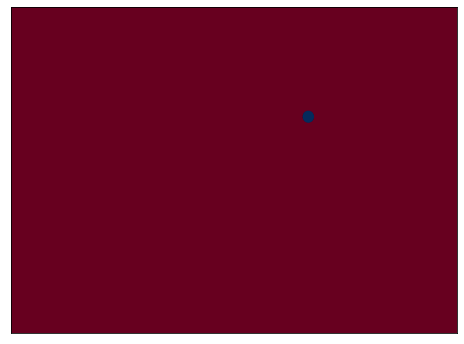

In [52]:
plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))

# evaluate decision function in a grid
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
    
# visualize parameter's effect on decision function
plt.pcolormesh(xx, yy, -Z, cmap= 'RdBu')

# plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu_r, edgecolors='k')
plt.scatter(df['norm_date'], df['norm_time'], s = 100, c = city_dum, cmap ='RdBu_r', alpha = 0.2)


plt.xticks(())
plt.yticks(())
plt.axis('tight')

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

In [ ]:
# #############################################################################
# Visualization
#
# draw visualization of parameter effects

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r,
                edgecolors='k')
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

In [43]:
clf.predict(np.array(df[['date','time']].iloc[0]).reshape(1, -1))

array(['Kirkuk'], dtype=object)

In [45]:
clf.predict(np.array(df[['date','time']].iloc[-1]).reshape(1, -1))

array(['Baghdad'], dtype=object)

In [44]:
df[['date','time']].iloc[-1]

date    20090930
time      174524
Name: 67, dtype: int64

# Old jizzz

In [125]:
np.random.seed(2015)
df = pd.DataFrame([])

for img_path in city_imgs:
    im = Image.open(img_path)
    info = IptcImagePlugin.getiptcinfo(im)    
    
#     data = dict(zip(np.random.choice(10, replace=False, size=5),
#                     np.random.randint(10, size=5)))
    
    img_id = img_path
    city = info[city_info]
    date = info[date_info]
    time = info[time_info]
    
    data = {'id':img_id,'city': city, 'date':date, 'time':time}
    
    data = pd.DataFrame(data.items())
    data = data.transpose()
    data.columns = data.iloc[0]
    data = data.drop(data.index[[0]])
    df = df.append(data)

In [126]:
df

,id,city,date,time
1,/home/xpn381/data/johan_test2/1568884391729434...,b'Kirkuk',b'20090929',b'103508+0100'
1,/home/xpn381/data/johan_test2/1568884391729925...,b'Kirkuk',b'20090929',b'103537+0100'
1,/home/xpn381/data/johan_test2/1568884391730428...,b'Kirkuk',b'20090929',b'103943+0100'
1,/home/xpn381/data/johan_test2/1568884391730990...,b'Kirkuk',b'20090929',b'104021+0100'
1,/home/xpn381/data/johan_test2/1568884391732055...,b'Kirkuk',b'20090929',b'104726+0100'
...,...,...,...,...
1,/home/xpn381/data/johan_test2/1568884391765128...,b'Baghdad',b'20090930',b'172634+0300'
1,/home/xpn381/data/johan_test2/1568884391765671...,b'Baghdad',b'20090930',b'172704+0300'
1,/home/xpn381/data/johan_test2/1568884391766176...,b'Baghdad',b'20090930',b'172718+0300'
1,/home/xpn381/data/johan_test2/1568884391766650...,b'Baghdad',b'20090930',b'173836+0300'


In [121]:
df['city'].unique()

array([b'Baghdad'], dtype=object)

In [104]:
city_imgs = get_city_imgs(linux_dir2)

city_info = (2, 90)
date_info = (2, 55)
time_info = (2, 60)

df = pd.DataFrame(columns = {'id':'0', 'city':'1', 'date':'2', 'time':'3'})

for img_path in city_imgs:
    im = Image.open(img_path)
    info = IptcImagePlugin.getiptcinfo(im)
        
    img_id = img_path
    city = info[city_info]
    date = info[date_info]
    time = info[time_info]
    
    temp_df = pd.DataFrame({'id':[img_id],'city': [city], 'date':[date], 'time':[time]})
    
    pd.concat([df,temp_df])
    
#     print(info[city_info])
#     print(info[date_info])
#     print(info[time_info])
    
#     row = pd.Series([img_id, city_info,date_info,time_info])
#     row = {'id':img_id, 'city':info[city_info], 'date':info[date_info], 'time':info[time_info]}
#     row = {img_id:'id', info[city_info]:'city', info[date_info]:'date', info[time_info]:'time'}
    
#     print(row)

#     row = [img_id, info[city_info], info[date_info], info[time_info]]

    
#     dt.append(row, ignore_index = True)
    
#     datadict['city'] = city_info
#     datadict['date'] = date_info
#     datadict['time'] = time_info
    
#     print(info[(2, 90)])
#     print(info, '\n')    

In [106]:
temp_df

,id,city,date,time
0,/home/xpn381/data/johan_test2/1568884391767136...,b'Baghdad',b'20090930',b'174524+0300'


In [105]:
df

,id,city,date,time


In [96]:
city_imgs = get_city_imgs(linux_dir2)

city_info = (2, 90)
date_info = (2, 55)
time_info = (2, 60)

dt = pd.DataFrame(columns = {'id':'0', 'city':'1', 'date':'2', 'time':'3'})
             
for img_path in city_imgs:
    im = Image.open(img_path)
    info = IptcImagePlugin.getiptcinfo(im)
        
    img_id = img_path
    
#     print(info[city_info])
#     print(info[date_info])
#     print(info[time_info])
    
#     row = pd.Series([img_id, city_info,date_info,time_info])
#     row = {'id':img_id, 'city':info[city_info], 'date':info[date_info], 'time':info[time_info]}
#     row = {img_id:'id', info[city_info]:'city', info[date_info]:'date', info[time_info]:'time'}
    
#     print(row)

    row = [img_id, info[city_info], info[date_info], info[time_info]]

    
    dt.append(row, ignore_index = True)
    
#     datadict['city'] = city_info
#     datadict['date'] = date_info
#     datadict['time'] = time_info
    
#     print(info[(2, 90)])
#     print(info, '\n')    

In [97]:
dt

,id,city,date,time


In [83]:
pd.concat?

Signature:
pd.concat(
    objs,
    axis=0,
    join='outer',
    join_axes=None,
    ignore_index=False,
    keys=None,
    levels=None,
    names=None,
    verify_integrity=False,
    sort=None,
    copy=True,
)
Docstring:
Concatenate pandas objects along a particular axis with optional set logic
along the other axes.

Can also add a layer of hierarchical indexing on the concatenation axis,
which may be useful if the labels are the same (or overlapping) on
the passed axis number.

Parameters
----------
objs : a sequence or mapping of Series or DataFrame objects
    If a dict is passed, the sorted keys will be used as the `keys`
    argument, unless it is passed, in which case the values will be
    selected (see below). Any None objects will be dropped silently unless
    they are all None in which case a ValueError will be raised.
axis : {0/'index', 1/'columns'}, default 0
    The axis to concatenate along.
join : {'inner', 'outer'}, default 'outer'
    How to handle indexes on othe

In [79]:
dt.append?

Signature: dt.append(other, ignore_index=False, verify_integrity=False, sort=None)
Docstring:
Append rows of `other` to the end of caller, returning a new object.

Columns in `other` that are not in the caller are added as new columns.

Parameters
----------
other : DataFrame or Series/dict-like object, or list of these
    The data to append.
ignore_index : boolean, default False
    If True, do not use the index labels.
verify_integrity : boolean, default False
    If True, raise ValueError on creating index with duplicates.
sort : boolean, default None
    Sort columns if the columns of `self` and `other` are not aligned.
    The default sorting is deprecated and will change to not-sorting
    in a future version of pandas. Explicitly pass ``sort=True`` to
    silence the warning and sort. Explicitly pass ``sort=False`` to
    silence the warning and not sort.

    .. versionadded:: 0.23.0

Returns
-------
DataFrame

See Also
--------
concat : General function to concatenate DataFra

In [11]:
datadict

{'city': (2, 90), 'date': (2, 55), 'time': (2, 60)}

In [13]:
import pandas as pd

In [18]:
row1 = pd.Series(['id1','århus',20122012,1330])
row2 = pd.Series(['id2','kbh',21112014,1545])

In [56]:
# dt = pd.DataFrame([row1,row2]) 
dt = pd.DataFrame() 

dt.columns = {'id':'0', 'city':'1', 'date':'2', 'time':'3'}

ValueError: Length mismatch: Expected axis has 0 elements, new values have 4 elements

In [60]:
dt = pd.DataFrame(columns = {'id':'0', 'city':'1', 'date':'2', 'time':'3'})

In [ ]:
dt = pd.DataFrame.empty

In [61]:
dt

,id,city,date,time


In [21]:
pd.DataFrame?

Init signature: pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)
Docstring:     
Two-dimensional size-mutable, potentially heterogeneous tabular data
structure with labeled axes (rows and columns). Arithmetic operations
align on both row and column labels. Can be thought of as a dict-like
container for Series objects. The primary pandas data structure.

Parameters
----------
data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
    Dict can contain Series, arrays, constants, or list-like objects

    .. versionchanged :: 0.23.0
       If data is a dict, column order follows insertion-order for
       Python 3.6 and later.

    .. versionchanged :: 0.25.0
       If data is a list of dicts, column order follows insertion-order
       Python 3.6 and later.

index : Index or array-like
    Index to use for resulting frame. Will default to RangeIndex if
    no indexing information part of input data and no index provided
columns : Index or array-l

In [14]:
pd.Series?

Init signature:
pd.Series(
    data=None,
    index=None,
    dtype=None,
    name=None,
    copy=False,
    fastpath=False,
)
Docstring:     
One-dimensional ndarray with axis labels (including time series).

Labels need not be unique but must be a hashable type. The object
supports both integer- and label-based indexing and provides a host of
methods for performing operations involving the index. Statistical
methods from ndarray have been overridden to automatically exclude
missing data (currently represented as NaN).

Operations between Series (+, -, /, *, **) align values based on their
associated index values-- they need not be the same length. The result
index will be the sorted union of the two indexes.

Parameters
----------
data : array-like, Iterable, dict, or scalar value
    Contains data stored in Series.

    .. versionchanged :: 0.23.0
       If data is a dict, argument order is maintained for Python 3.6
       and later.

index : array-like or Index (1d)
    Values must

In [69]:
for img in os.listdir(linux_dir2):
    img_path = os.path.join(linux_dir2, img)

    city_imgs = [] # list of images with city in them:
    
    with Image.open(img_path) as im:
        
        info = IptcImagePlugin.getiptcinfo(im)
        
        if info != None:
            if (2, 90) in info.keys(): # (2, 90) = city
        
#                 print(info[(2, 90)], '\n') # (2, 90) = city
            
                city_imgs.append(img_path)
            
            else:
                pass
city_imgs

[]

In [ ]:
(2, 55)

In [ ]:
(2, 60)

In [ ]:
(2, 90)

In [ ]:
(2, 120)

In [40]:
for img in os.listdir(linux_dir1edit):
    img_path = os.path.join(linux_dir1edit, img)
#     print(img_path)
    with Image.open(img_path) as i:
        info = i._getexif()
        
        print(img_path, info, '\n')
        
    break

/home/xpn381/data/johan_test1/edit/JSpanner_Petraeus_0959.JPG {36864: b'0220', 37121: b'\x01\x02\x03\x00', 37122: (4, 1), 36867: '2007:07:28 11:07:34', 36868: '2007:07:28 11:07:34', 37380: (-4, 6), 37381: (30, 10), 37383: 5, 37384: 11, 37385: 0, 37386: (200, 10), 37510: b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 40961: 1, 40962: 3008, 270: '                               ', 271: 'NIKON CORPORATION', 272: 'NIKON D1X', 37520: '50', 274: 1, 531: 2, 37521: '50', 37522: '50', 40963: 1960, 41495: 2, 41728: b'\x03', 282: (300, 1), 283: (300, 1), 40965: 900, 33434: (10, 600), 33437: (40, 10), 41729: b'\x01', 34850: 2, 41730: b'\x00\x02\x00\x02\x02\x01\x01\x00', 34853: {0: b'\x02\x02\x00\x00'}, 41985: 0, 296: 2, 41986: 0, 40960: b'0100', 41987: 1, 305: 'Adobe Photoshop CS Macintosh', 306: '2007:07:30 21:37:57', 41988: (1, 1), 41989: 30, 41990:

In [ ]:
def get_img_w_city():

    for img in os.listdir(linux_dir2):
        img_path = os.path.join(linux_dir2, img)
#     print(img_path)

        city_img = []

        info = IPTCInfo(img_path, force=True)
        if info['city'] == None:
            pass
    
        else:
            city_img.append(img_path)
            
        return()

In [24]:
def get_img_w_city():

    for img in os.listdir(linux_dir2):
        img_path = os.path.join(linux_dir2, img)
#     print(img_path)

        city_img = []

        info = IPTCInfo(img_path, force=True)
        if info['city'] == None:
            pass
    
        else:
            city_img.append(img_path)
            
        return()
        
#         print('IPTC')
#         print(img_path)
#         print(info['date created'])
#         print(info['time created'])
#         print(info['city'])
#         print(info['copyright notice'])
#         print(info['caption/abstract'])
#         print('\n\n')
#         edit_info = IPTCInfo(edit_image_path, force=True)
#         edit_date = str(edit_info['date created'])[2:10] # assumning this holds for all


In [25]:
get_img_w_city()

In [6]:
IPTCInfo?

Init signature: IPTCInfo(fobj, force=False, inp_charset=None, out_charset=None)
Docstring:     
info = IPTCInfo('image filename goes here')

File can be a file-like object or a string. If it is a string, it is
assumed to be a filename.

Returns IPTCInfo object filled with metadata from the given image
file. File on disk will be closed, and changes made to the IPTCInfo
object will *not* be flushed back to disk.

If force==True, than forces an object to always be returned. This
allows you to start adding stuff to files that don't have IPTC info
and then save it.

If inp_charset is None, then no translation is done to unicode (except
when charset is encoded in the image metadata). In this case you should
be VERY careful to use bytestrings overall with the SAME ENCODING!
File:           ~/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/iptcinfo3.py
Type:           type
Subclasses:     


# first 
Need reiterate through all img with IPTC and check/correct city/location. Do this by looking in describtion maybe using a list of town names and  Fuzzy String Matching (see https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ and here https://towardsdatascience.com/natural-language-processing-for-fuzzy-string-matching-with-python-6632b7824c49) ...


# then
now, you need to reiterate through all the images and sort for images with IPTC.. from these you need to get date, time and not least place!

pseudo code:  

for images in dir:  
    if image.IPTC exist:  
        date = image.IPTC.date  
        time = image.IPTC.time  
        city = image.IPTC.city  
        owner = image.IPTC.copyright  
           
  
        then....  
        You make a dict holding time, date, locale and some image id.. This dict is then converted into a pandas dataframe (see https://stackoverflow.com/questions/18837262/convert-python-dict-into-a-dataframe)   

        with this dataframe you should be able to classify - either hard-code or via e.g k-nearest neighbor - the raw (no IPTC) images. 
        also you need here to consider transport images..  

# old:


- Reiterate through IPTC images getting date and location.
- Also get first and last time for said date to remove "transport" images. (see if that solves it..)
- Now, for each 'i' in w_IPTC  reiterate through each 'j' in no_IPTC matching on date and interpolating locale if time is between first and last in w_IPCT.

....